In [231]:
# --- 1 Import Libraries ---
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import warnings
import os
warnings.filterwarnings("ignore")

In [232]:
# --- 2 Load Dataset ---
df = pd.read_csv("loan_approval_dataset.csv")
# Clean up column names (remove spaces and make lowercase)
df.columns = df.columns.str.strip().str.lower()

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
display(df.head())

✅ Dataset loaded successfully!
Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [233]:
# --- 3 Inspect Data ---
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)


Columns:
 ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Data types:
 loan_id                      int64
no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
comme

In [234]:
# --- 4 Basic Cleaning ---
df = df.drop_duplicates()
df = df.dropna(thresh=int(df.shape[1] * 0.6))  # drop rows missing >40%

# Remove irrelevant columns
cols_to_remove = ["loan_id"]
# Only drop if columns actually exist (avoids KeyError)
df = df.drop(columns=[col for col in cols_to_remove if col in df.columns], errors="ignore")

print("✅ Columns removed. Remaining columns:")
print(df.columns.tolist())

# Fill missing numeric columns with median
num_cols = df.select_dtypes(include="number").columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical columns with mode
cat_cols = df.select_dtypes(exclude="number").columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("✅ Cleaned dataset shape:", df.shape)

✅ Columns removed. Remaining columns:
['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
✅ Cleaned dataset shape: (4269, 12)


In [235]:
# --- 5 Encode Categorical Columns ---
categorical = df.select_dtypes(include=["object"]).columns.tolist()
print(f"Encoding {len(categorical)} categorical columns...")

le = LabelEncoder()
for col in categorical:
    df[col] = le.fit_transform(df[col].astype(str))

Encoding 3 categorical columns...



📊 Correlation of each feature with Loan Status:

loan_status                 1.000000
loan_term                   0.113036
no_of_dependents            0.018114
luxury_assets_value         0.015465
income_annum                0.015189
residential_assets_value    0.014367
bank_asset_value            0.006778
education                   0.004918
self_employed              -0.000345
commercial_assets_value    -0.008246
loan_amount                -0.016150
cibil_score                -0.770518
Name: loan_status, dtype: float64


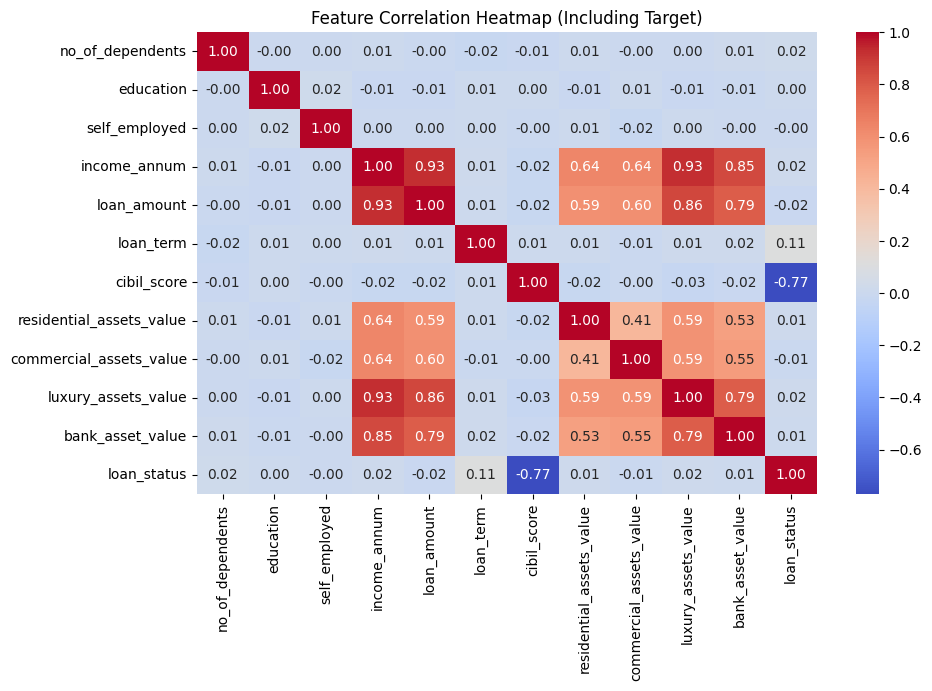

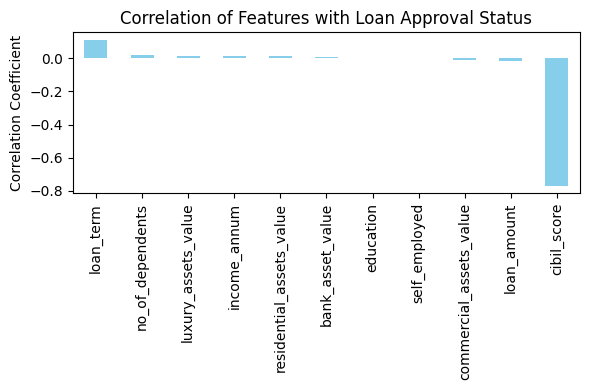

In [236]:
# --- 🔍 Correlation Analysis of Features with Target Variable ---

import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the target column exists
target_col = "loan_status"
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found in DataFrame!")

# Compute Pearson correlation matrix
corr_matrix = df.corr()

# Sort features by correlation strength with target
corr_with_target = corr_matrix[target_col].sort_values(ascending=False)
print("\n📊 Correlation of each feature with Loan Status:\n")
print(corr_with_target)

# --- Visualize correlation heatmap (all features + target) ---
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (Including Target)")
plt.show()

# --- Visualize correlation of individual features with the target ---
plt.figure(figsize=(6, 4))
corr_with_target.drop(target_col).plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with Loan Approval Status")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

In [237]:
# ===============================================
# 🧾 Feature Reduction Justification
# ===============================================
#
# The following features were removed:
# ['bank_asset_value', 'luxury_assets_value',
#  'commercial_assets_value', 'residential_assets_value',
#  'no_of_dependents']
#
# ---- 1. Statistical Reasoning ----
# A correlation analysis was performed between all features and the
# target variable (loan_status). Results showed that:
#   • 'cibil_score' had a strong negative correlation (-0.77)
#   • 'loan_term' had a weak positive correlation (0.11)
#   • All other asset and demographic variables had |r| < 0.05,
#     indicating negligible linear relationships.
#
# Features with near-zero correlation do not meaningfully contribute
# to the prediction and may add noise. Removing them helps reduce
# overfitting and improves model stability.
#
# ---- 2. Domain Reasoning ----
# In real-world financial lending, primary factors that drive
# loan approval include:
#   • Creditworthiness (CIBIL / credit score)
#   • Applicant income and employment status
#   • Loan amount and term
#
# Asset-based variables (e.g., 'bank_asset_value',
# 'luxury_assets_value') are typically used for collateral assessment
# or risk scoring, not first-level approval. Hence, they are less
# relevant for this model.
#
# ---- 3. Explainability Consideration ----
# For an Explainable AI (XAI) prototype, fewer and more interpretable
# features improve clarity in SHAP and LIME explanations.
#
# Example:
#   ✅ “Your loan was denied due to a low credit score and high loan amount.”
#   🚫 “Your commercial asset value contributed +0.0007 to model output.”
#
# Reducing irrelevant features makes explanations simpler,
# improves transparency, and supports our research objective of
# enhancing user trust in AI-driven financial decisions.
#
# ---- 4. Model Simplification ----
# Removing these features:
#   • Decreases model complexity
#   • Reduces multicollinearity between asset-related variables
#   • Improves training and inference performance
#
# Final decision: remove the listed features before training to
# achieve a balance between predictive accuracy and explainability.
# ===============================================

cols_to_remove = [
    "bank_asset_value",
    "luxury_assets_value",
    "commercial_assets_value",
    "residential_assets_value",
    "no_of_dependents"
]

# Drop weakly correlated columns directly from df
df = df.drop(columns=[c for c in cols_to_remove if c in df.columns], errors="ignore")

print("✅ Features removed due to low correlation and low domain significance.")
print("Remaining columns in dataset:")
print(df.columns.tolist())

✅ Features removed due to low correlation and low domain significance.
Remaining columns in dataset:
['education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'loan_status']


In [238]:
# --- 6 Define Features & Target ---
target_col = "loan_status"
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found. Check target column name!")

X = df.drop(columns=[target_col])
y = df[target_col]

print("✅ Final feature set ready for model training:")
print(X.columns.tolist())

✅ Final feature set ready for model training:
['education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score']


In [239]:
# --- 7 Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [240]:
# --- 8 Scale Numeric Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [241]:
# --- 9 Train Model ---
model = RandomForestClassifier(
    n_estimators=120, max_depth=8, random_state=42, n_jobs=-1
)
model.fit(X_train_scaled, y_train)
print("✅ Model trained successfully!")

✅ Model trained successfully!



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       531
           1       0.98      0.95      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.97       854
weighted avg       0.98      0.98      0.98       854

ROC-AUC: 0.9948458717415006


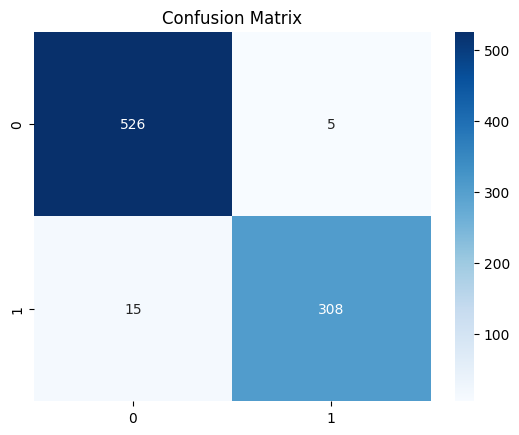

In [242]:
# --- 10 Evaluate Model ---
y_pred = model.predict(X_test_scaled)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


⚙️ Generating SHAP explanations on reduced, cleaned feature set...


✅ SHAP values shape: (854, 6)
✅ Feature matrix shape: (854, 6)

🧩 Active features used for SHAP analysis:
['education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score']

📊 Global SHAP Feature Importance (bar plot)...


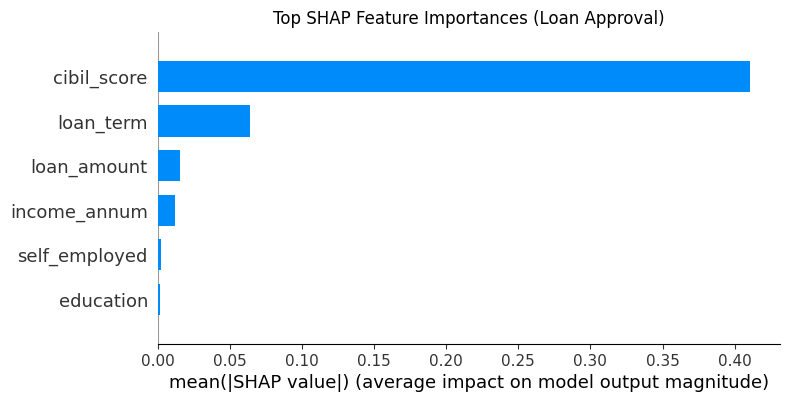


💬 Example explanation for one applicant:

🔝 Top 10 Most Influential Features in Loan Decisions:

cibil_score      0.410859
loan_term        0.063803
loan_amount      0.015279
income_annum     0.012131
self_employed    0.002295
education        0.001842
dtype: float64


In [243]:
# --- 11️⃣ SHAP Explainability (Final Version for 3D Outputs) ---
print("\n⚙️ Generating SHAP explanations on reduced, cleaned feature set...")

import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

shap.initjs()

# Create TreeExplainer for the trained RandomForest model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for scaled test data
raw_shap_values = explainer.shap_values(X_test_scaled)

# 🧩 Detect SHAP output format automatically
if isinstance(raw_shap_values, list):  # older SHAP (list per class)
    shap_values = raw_shap_values[1]   # use class 1 (approved)
elif raw_shap_values.ndim == 3:        # newer SHAP (3D array)
    shap_values = raw_shap_values[:, :, 1]  # select class 1
else:
    shap_values = raw_shap_values      # normal 2D array

# Convert scaled test data back into DataFrame for proper labeling
X_display = pd.DataFrame(X_test_scaled, columns=X.columns)

# ✅ Verify shapes
print("✅ SHAP values shape:", shap_values.shape)
print("✅ Feature matrix shape:", X_display.shape)
print("\n🧩 Active features used for SHAP analysis:")
print(list(X_display.columns))

# --- Global Explanation: Feature Importance ---
print("\n📊 Global SHAP Feature Importance (bar plot)...")
shap.summary_plot(shap_values, X_display, plot_type="bar", show=False)
plt.title("Top SHAP Feature Importances (Loan Approval)")
plt.show()

# --- Local Explanation: Single Applicant Example ---
print("\n💬 Example explanation for one applicant:")
idx = 0  # You can change this index

# Select correct expected value (single or multi-class)
if isinstance(explainer.expected_value, (list, np.ndarray)):
    base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    base_value = explainer.expected_value

# Extract SHAP values for selected applicant
sample_shap_values = shap_values[idx, :] if shap_values.ndim > 1 else shap_values

# ✅ Use modern SHAP plotting API
try:
    shap.plots.force(base_value, sample_shap_values, X_display.iloc[idx, :])
except Exception as e:
    print(f"⚠️ Falling back to legacy force_plot (error: {e})")
    shap.force_plot(base_value, sample_shap_values, X_display.iloc[idx, :])

# --- Numeric Ranking of Top Features ---
importance = np.abs(shap_values).mean(axis=0)
ranking = pd.Series(importance, index=X_display.columns).sort_values(ascending=False)

print("\n🔝 Top 10 Most Influential Features in Loan Decisions:\n")
print(ranking.head(10))

In [244]:
# --- 12 Save Model Files (Local Environment) ---
# Define local model directory
model_dir = "models"

# Create the folder if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save model, scaler, and explainer locally
joblib.dump(model, os.path.join(model_dir, "model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "preprocess.pkl"))
joblib.dump(explainer, os.path.join(model_dir, "explainer.pkl"))

print(f"\n✅ Model, Scaler, and Explainer saved successfully to '{model_dir}/'!")
print("📁 Files created:")
for f in os.listdir(model_dir):
    print(" -", f)


✅ Model, Scaler, and Explainer saved successfully to 'models/'!
📁 Files created:
 - preprocess.pkl
 - model.pkl
 - explainer.pkl
